In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

!git clone https://github.com/invite-you/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.15)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-3cr7lrr1
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-3cr7lrr1
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-s5nuou8e
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-s5nuou8e
     |████████████████████████████████| 276kB 55.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=41712 sha256=d77948f34b34699a62d0e86f02b87c205aa69c44f97591d9d6e99e991881b66b
  Stored in directory: /tmp/pip-ephem-wheel-cache-cixlu20c/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

In [0]:
# 인스톨이 완료되면 Colab Runtime을 다시 시작해주세요. 

# 기본 설정
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random
import os
from google.colab.patches import cv2_imshow

import glob
import math

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
base_dir = r"/content/gdrive/My Drive/findShip/custom_coco/"

annt_file = os.path.join(base_dir, 'annotations', "instances_train2017.json")
image_dir = os.path.join(base_dir, 'train2017')

register_coco_instances("ship_dataset_train", {}, annt_file, image_dir)

annt_file = os.path.join(base_dir, 'annotations', "instances_val2017.json")
image_dir = os.path.join(base_dir, 'val2017')

register_coco_instances("ship_dataset_test", {}, annt_file, image_dir)

train_metadata = MetadataCatalog.get("ship_dataset_train")
train_dicts = DatasetCatalog.get("ship_dataset_train")

test_metadata = MetadataCatalog.get("ship_dataset_test")
test_dicts = DatasetCatalog.get("ship_dataset_test")


[03/05 08:34:05 d2.data.datasets.coco]: Loaded 7904 images in COCO format from /content/gdrive/My Drive/findShip/custom_coco/annotations/instances_train2017.json
[03/05 08:34:05 d2.data.datasets.coco]: Loaded 201 images in COCO format from /content/gdrive/My Drive/findShip/custom_coco/annotations/instances_val2017.json


In [4]:
ls -alt "/content/gdrive/My Drive/findShip/custom_coco/models/mask_rcnn_R_101_FPN_3x_frezzereal-1"

total 3450664
-rw------- 1 root root    195354 Mar  5 08:07 events.out.tfevents.1583390249.ae3bbdd386f9.1507.0
-rw------- 1 root root   2059332 Mar  5 08:07 metrics.json
-rw------- 1 root root 504053899 Mar  5 08:07 model_final.pth
-rw------- 1 root root        15 Mar  5 08:07 last_checkpoint
-rw------- 1 root root 504053899 Mar  5 07:28 model_0047999.pth
-rw------- 1 root root      2260 Mar  5 06:36 events.out.tfevents.1583390110.ae3bbdd386f9.1344.0
-rw------- 1 root root     58870 Mar  5 06:06 events.out.tfevents.1583388414.ae3bbdd386f9.493.1
-rw------- 1 root root 504053919 Mar  5 05:57 model_0045999.pth
-rw------- 1 root root    112104 Mar  5 05:06 events.out.tfevents.1583384793.ae3bbdd386f9.493.0
-rw------- 1 root root        40 Mar  5 04:55 events.out.tfevents.1583384101.630a45be0211.445.2
-rw------- 1 root root 504054873 Mar  5 04:32 model_0043999.pth
-rw------- 1 root root 504054873 Mar  5 03:47 model_0041999.pth
-rw------- 1 root root    167604 Mar  5 03:23 events.out.tfevents

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


pretrained_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()

cfg.OUTPUT_DIR = os.path.join(base_dir, 'models', 'mask_rcnn_R_101_FPN_3x_frezzereal-1')

cfg.merge_from_file(
  model_zoo.get_config_file( pretrained_model)
)
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model)
cfg.MODEL.WEIGHTS = os.path.join(base_dir, 'models', 'mask_rcnn_R_101_FPN_3x_frezzereal-1', "model_final.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "last_checkpoint")

cfg.MODEL.BACKBONE.FREEZE_AT = 0

cfg.INPUT.CROP.ENABLED = True

cfg.INPUT.MAX_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)

cfg.DATALOADER.REPEAT_THRESHOLD = 1.0

cfg.MODEL.RPN.NMS_THRESH = 0.25
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.25
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.25

cfg.DATASETS.TRAIN = ("ship_dataset_train", "ship_dataset_test")
cfg.DATASETS.TEST = ("ship_dataset_test",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 15

cfg.MODEL.ANCHOR_GENERATOR.ANGLES: [[-15, -30, -45, -60, -75, -90, -105, -120, -135, -150, -165, -180, -270, -285, -300, -315, -330, -345, 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 270, 285, 300, 315, 330, 345]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]]
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512], [1000]]

cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.02#0.2
cfg.SOLVER.MAX_ITER = 39000    # 300 iterations seems good enough, but you can certainly train longer
cfg.SOLVER.STEPS = (30000,)
cfg.SOLVER.GAMMA = 0.05#0.5
cfg.SOLVER.MOMENTUM = 0.05#0.09#0.9
cfg.SOLVER.CHECKPOINT_PERIOD = 2000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_metadata.thing_classes)  # only has one class (ballon)

"""
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
"""

# Create predictor
predictor = DefaultPredictor(cfg)

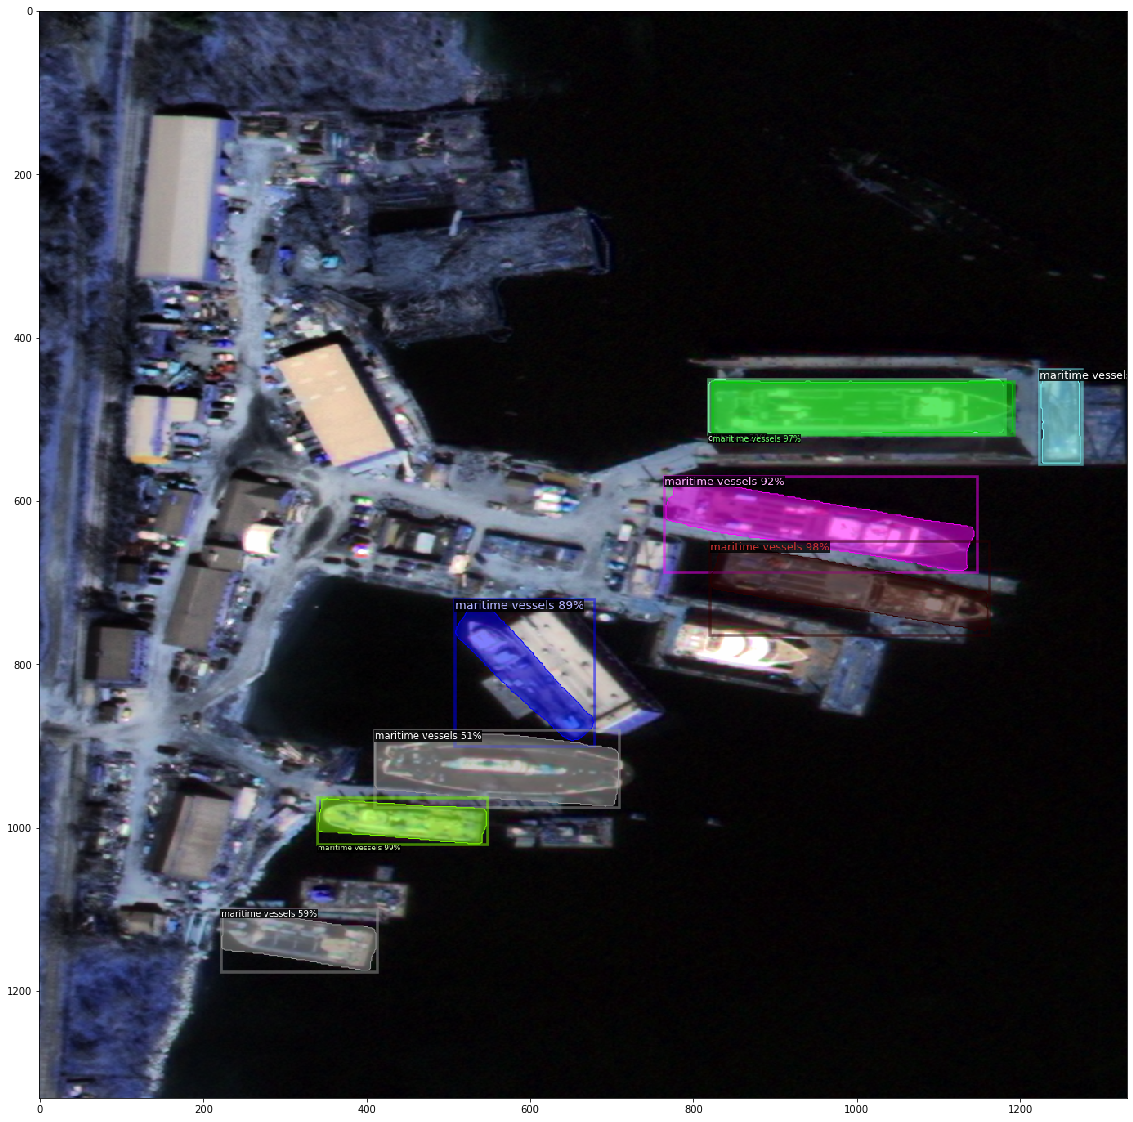

In [7]:
image_file = '/content/gdrive/My Drive/findShip/images/0.png'
image_file = '/content/gdrive/My Drive/findShip/custom_coco/val2017/0_1280_1920.png'
img = cv2.imread(image_file)
# Make prediction
outputs = predictor(img)

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.3)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (20,20))
plt.imshow(v.get_image()[:, :, ::-1])


In [9]:
from tqdm import tqdm
import glob

allpreds={}

image_size = 1024
base_path = "/content/gdrive/My Drive/findShip/test_images/*"

path = glob.glob(base_path)
files = [file for file in path if file.endswith(".png")]

for file in tqdm(files):
    img = cv2.imread(file)
    #plt.imshow(img, interpolation='nearest')  
    height, width, _ = img.shape

    loopx = math.ceil(width / image_size)
    loopy = math.ceil(height / image_size)

    for x in range(0, loopx):
        minX = image_size * x
        maxX = image_size * (x+1)
        if maxX > width:
            minX = width - image_size
            maxX = width        
        for y in range(0, loopy):
            minY = image_size * y
            maxY = image_size * (y+1)
            if maxY > height:
                minY = height - image_size
                maxY = height

            #plt.figure()
            #plt.imshow(img[minY:maxY, minX:maxX])

            # CSV 만들기 시작
            outputs = predictor(img[minY:maxY, minX:maxX])

            scores = outputs['instances'].scores.to("cpu").tolist()

            classes = outputs['instances'].pred_classes.to("cpu").tolist()

            masks = np.array(outputs['instances'].pred_masks.to("cpu"), dtype=bool)
            masks = masks.astype(np.int8)


            for score, cls, mask in zip(scores, classes, masks):
                # 회전 박스 구하기
                mask_8bit = np.uint8(mask * 255)
                threshold_level = 127 # Set as you need...
                _, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                contour = max(contours, key = cv2.contourArea)
                
                rbox = cv2.minAreaRect(contour)
                box = cv2.boxPoints(rbox)
                
                # 클레스 값 구하기
                filename = os.path.basename(file)
                if not filename in allpreds:
                    allpreds[filename]=list()
                allpreds[filename].append({
                    'class_id': cls+1,
                    'confidence': score,
                    'bbox': [ [x+minX, y+minY] for x, y in box.tolist() ]
                })

100%|██████████| 1240/1240 [1:03:24<00:00,  3.07s/it]


In [10]:
from shapely.geometry import Polygon

for filename in allpreds:
    delpos = []
    preds = allpreds[filename]
    # 비교
    preds = sorted(preds, key=lambda x: x['confidence'], reverse=True)
    for pred_idx1 in range(len(preds)):
        for pred_idx2 in range(pred_idx1+1, len(preds)):
            poly1 = Polygon(preds[pred_idx1]['bbox'])
            poly2 = Polygon(preds[pred_idx2]['bbox'])
            iou = poly1.intersection(poly2).area / poly1.area
            if 0.3 < iou:
                delpos.append(pred_idx2)
    print(len(delpos))
    for pos in sorted(delpos, reverse=True):
        preds.pop(pos)
    allpreds[filename] = preds


1
1
0
1
1
1
0
10


IndexError: ignored

In [0]:
base_dir = '/content/gdrive/My Drive/findShip/test_images/'

for filename in allpreds[-3:]:
    preds = allpreds[filename]
    image = cv2.imread(os.path.join(base_dir, filename))
    for pred in preds:
        forimagebox = np.int0(pred['bbox'])
        cv2.drawContours(image, [forimagebox], 0, (0, 255, 0), 3)
    plt.figure(figsize = (18,18))
    plt.imshow(image)
    #cv2_imshow(image)


In [0]:
import csv
def generator_filename():
    import datetime
    basename = "result"
    suffix = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
    filename = "_".join([basename, suffix])
    return filename

dst_path = "/content/gdrive/My Drive/findShip/custom_coco/results/" + generator_filename() + ".csv"

with open(dst_path, 'w') as f:
    w = csv.DictWriter(f, ['file_name', 'class_id', 'confidence', 'point1_x', 'point1_y', 'point2_x', 'point2_y',
                            'point3_x', 'point3_y', 'point4_x', 'point4_y'])
    for filename in allpreds:
        preds = allpreds[filename]
        for pred in preds:
            bbox = pred['bbox']        
            w.writerow({
                'file_name': filename,
                'class_id': pred['class_id'],
                'confidence': pred['confidence'],
                'point1_x': bbox[0][0],
                'point1_y': bbox[0][1],
                'point2_x': bbox[1][0],
                'point2_y': bbox[1][1],
                'point3_x': bbox[2][0],
                'point3_y': bbox[2][1],
                'point4_x': bbox[3][0],
                'point4_y': bbox[3][1],
            })


In [0]:
image = img.copy()
contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contour = max(contours, key = cv2.contourArea)
rbox = cv2.minAreaRect(contour)
box = cv2.boxPoints(rbox)

## 이미지 출력
forimagebox = np.int0(box)
adjust_box = np.array([ [x+minX, y+minY] for x, y in forimagebox.tolist() ])
cv2.drawContours(image, [adjust_box], 0, (0, 255, 0), 3)

cv2_imshow(image)